In [1]:
# Por si alguien corre en python2
from __future__ import division

# Preparamos todo para correr
import numpy as np
from math import *
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import norm, binom, gamma, poisson, multivariate_normal
from sklearn import linear_model

import pandas as pd
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sklearn.preprocessing as pp
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

## Ejercicio 1: Fitteando una recta ruidosa de manera Bayesiana.

Como primer ejemplo de regresión lineal, tratemos de fittear los parametros $a_{0}$, $a_{1}$ de una recta $f(x,\vec{a}) = a_0 + a_{1}x$ donde $x$ está en el intervalo $[-1,1)$.

* **A)** Genere un set artificial de datos usando, usando como valores $a_{1} = 0.5$, $a_{0}= -0.3$. Añada a las mediciones ruido gaussiano  $\epsilon \sim \mathcal{N}(\mu=0, \sigma = 0.2)$. 
Al terminar debería tener un conjunto de $N= 100$  pares $(x_n,t_n)$, con 
$t_n = f(x_n,\vec{a}) + \epsilon$.

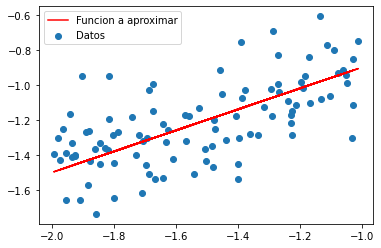

In [10]:
np.random.seed(42)
a0, a1 = -0.3, 0.6
var = 0.2
N = 100
x = -2.0 + np.random.rand(N)
f = a0+a1*x
t = a0+a1*x+var*np.random.randn(N)
plt.scatter(x,t,label='Datos')
plt.plot(x,f,color='red',label='Funcion a aproximar')
plt.legend(loc='upper left')

* **B)** Como modelo usaremos una regresión lineal de la forma $y(x) = \omega_0 + \omega_1 x$. ¿Cuál base de funciones $\phi_j$ estamos usando? (recuerde que por convención $\phi_0(x)=1$). 
Escriba para estos la matriz de diseño.
$$\Phi = \begin{pmatrix}
\phi_0(x_1) & \phi_1(x_1)\\
\phi_0(x_2) & \phi_1(x_2)\\
\vdots & \vdots\\
\phi_0(x_N) & \phi_1(x_N)\\
\end{pmatrix}$$

In [13]:
Phi=np.vstack((x**0.0,x)).T
print(Phi.shape)
print(Phi[0])

(100, 2)
[ 1.         -1.62545988]


* **C)** Estamos interesados en encontrar los valores de $\omega_0$ y $\omega_1$ de nuestro modelo más probables, dado los datos que tenemos. Estos están dados por el máximo de nuestra distribución posterior. Si usamos priors uniformes en $\omega_0$ y $\omega_1$ para caracterizar nuestro desconocimiento, el máximo del posterior coincide con el de la verosimilitud y es lo que llamamos el *estimador de máxima verosimilitud*. De acuerdo a lo visto en la teórica, dicho valor esta dado por 
$$\begin{pmatrix}
\omega_0^\text{ML}\\
\omega_1^\text{ML}\\
\end{pmatrix} 
= \left(\Phi^T \Phi\right)^{-1}\Phi^T \,\vec{t}
$$
donde recordemos que $\vec{t} = \begin{pmatrix}t_1\\ \vdots \\ t_N\end{pmatrix}$ es el vector de los valores *target* medidos.

Nota: Para un modelo lineal con error gaussiano, este estimador de maxima verosimilitud coincide con lo que se conoce como la solución de *cuadrados mínimos*.

* **D)** Si en vez de utilizar un prior uniforme, utilizamos un prior gaussiano de la forma $p(\vec{\omega}) = \mathcal{N} (\vec{0},\alpha^{-1}{\bf 1})$ (es decir que $p(\vec{\omega}) = p(\omega_0) \times p(\omega_1)$ con cada $p(\omega_i) = \mathcal{N} (\mu=0,\sigma = \alpha)$ ). Calcule la verosimilitud y el posterior (prior*posterior normalizado) al usar solo 1 punto, 2 puntos, 3 puntos y todo el conjunto de 100 puntos.


Si se le complica hacerlo en forma numerica, puede utilizar la formula analitica del posterior: Como este es un prior conjugado a la gaussiana en la teórica (o en su defecto, en el Bishop ecuacion 3.53), vimos que nuestro posterior es una gaussiana con valor medio
$$
\vec{m}_N = \beta {\bf S}_N \Phi^T \vec{t}\\
{\bf S}_N^{-1} = \alpha {\bf 1} + \beta \Phi^T \Phi
$$
donde $\beta$ es el parámetro de precisión del ruido gaussiano, que se supone conocido. En nuestro caso sería $\beta = (1/\sigma)^2 = (1/0.2)^2 = 25$. Para seleccionar la cantidad de puntos a considerar, puede usar slicing en $\vec{t}$ ( ``t[:N_puntos]``) y en $\Phi$ (``Phi[:N_puntos,:]``).

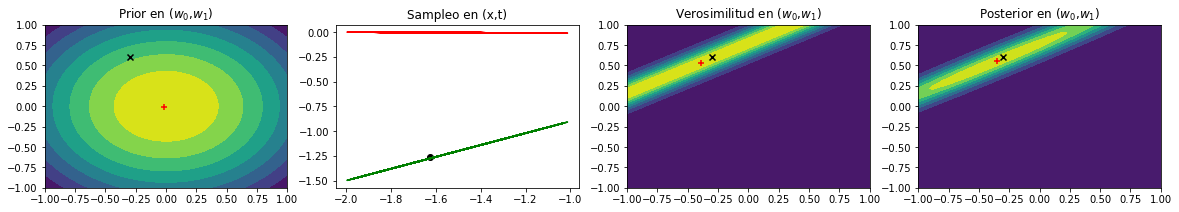

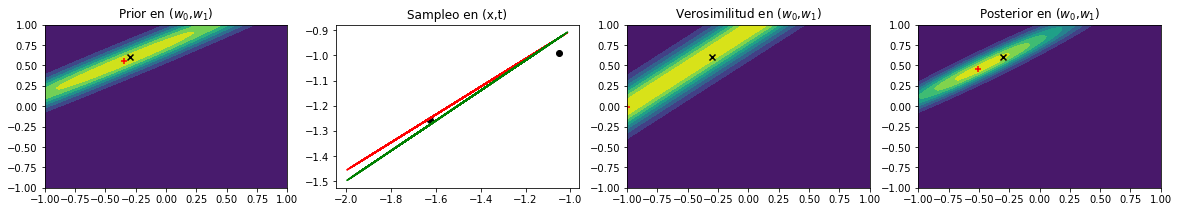

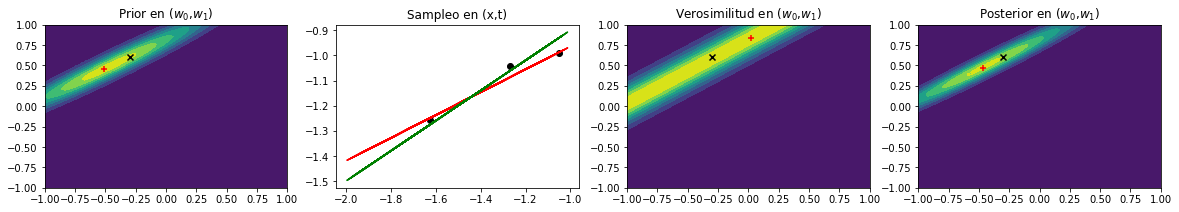

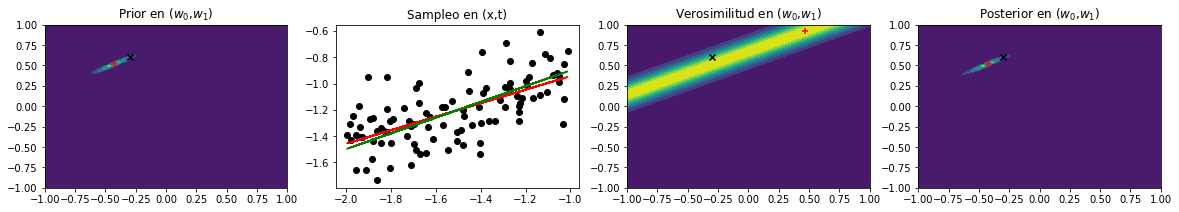

In [25]:
alpha=2.0
w0_values=np.linspace(-1.0,1.0,50)
w1_values=np.linspace(-1.0,1.0,100)
#para plottear
W0, W1 = np.meshgrid(w0_values,w1_values)
pos=np.dstack((W0,W1))
#print((W1.shape,W1.shape,pos.shape))
prior=[]
verosimilitud=[]
posterior=[]

#prior.append()#poner el prior inicial
# para el dato 0:
prior.append(multivariate_normal(mean=[0.0,0.0],cov=alpha*np.eye(2)).pdf(pos))
#print(prior[-1].shape)
# hago la inferencia para x[0],t[0]
for i in range(len(x)):
  verosimilitud.append(norm(loc=W0+W1*x[i],scale=var).pdf(t[i]))#formula de la verosimilitud para el dato 0
#print(verosimilitud[-1].shape)
  evidencia = np.sum(np.asarray(verosimilitud[-1])*np.asarray(prior[-1]))
  posterior.append(np.asarray(verosimilitud[-1])*np.asarray(prior[-1])/evidencia)

# sampleo puntos de (w0,w1) maximos para prior, verosimilitud y sampleo

  sampleo_prior=[W0[np.where(prior[-1]==np.max(prior[-1]))][0],W1[np.where(prior[-1]==np.max(prior[-1]))][0]]
  sampleo_verosimilitud=[W0[np.where(verosimilitud[-1]==np.max(verosimilitud[-1]))][0],W1[np.where(verosimilitud[-1]==np.max(verosimilitud[-1]))][0]]
  sampleo_posterior=[W0[np.where(posterior[-1]==np.max(posterior[-1]))][0],W1[np.where(posterior[-1]==np.max(posterior[-1]))][0]]

  if(i==0 or i==1 or i==2 or i==len(x)-1):
    fig, axes = plt.subplots(1,4, figsize=(20,3))
    axes[0].contourf(W0,W1,prior[-1])
    axes[0].scatter(a0,a1,marker='x',color='black')
    axes[0].scatter(sampleo_prior[0],sampleo_prior[1],marker='+',color='red')
    axes[0].set_title('Prior en ($w_0$,$w_1$)')
    axes[1].scatter(x[:i+1],t[:i+1],color='black')
    axes[1].plot(x,sampleo_prior[0]+sampleo_prior[1]*x,color='red')
    axes[1].plot(x,a0+a1*x,color='green')
    axes[1].set_title('Sampleo en (x,t)')
    axes[2].contourf(W0,W1,verosimilitud[-1])
    axes[2].scatter(a0,a1,marker='x',color='black')
    axes[2].scatter(sampleo_verosimilitud[0],sampleo_verosimilitud[1],marker='+',color='red')
    axes[2].set_title('Verosimilitud en ($w_0$,$w_1$)')
    axes[3].contourf(W0,W1,posterior[-1])
    axes[3].scatter(a0,a1,marker='x',color='black')
    axes[3].scatter(sampleo_posterior[0],sampleo_posterior[1],marker='+',color='red')
    axes[3].set_title('Posterior en ($w_0$,$w_1$)')

    fig.show()

# actualizo el prior
  prior.append(posterior[-1])

# Ejercicio 4: Cross-validation para comparación de modelos

En este ejercicio utilizaremos el set de datos de precios inmobiliarios en el estado de Boston, que viene con scikit-learn.

En la siguiente celda cargamos el dataset, y con el creamos un DataFrame de Pandas. Scikit-learn nos entrega un diccionario con los datos, el nombre de cada feature, el target, y una descripción general del dataset.

In [ ]:
from sklearn.datasets import load_boston

boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
#añadimos el target como una columna llamada 'MEDV'
boston['MEDV'] = boston_dataset.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Puede leer la descripción de cada feature ejecutando la siguiente celda

In [ ]:
print(boston_dataset.DESCR[296:1226])

        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's


El objetivo de este ejercicio es predecir el viviendas de Boston ("MEDV") a partir del resto de los features.

Para simplificar la tarea, solo consedere los dos features mas correlacionados con el target "MEDV". La siguiente lista, y los gráficos de correlación (ploteados por el muy util paquete ``seaborn``), pueden ayudarlo a elegir.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


MEDV       1.000000
LSTAT      0.737663
RM         0.695360
PTRATIO    0.507787
INDUS      0.483725
TAX        0.468536
NOX        0.427321
CRIM       0.388305
RAD        0.381626
AGE        0.376955
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
Name: MEDV, dtype: float64

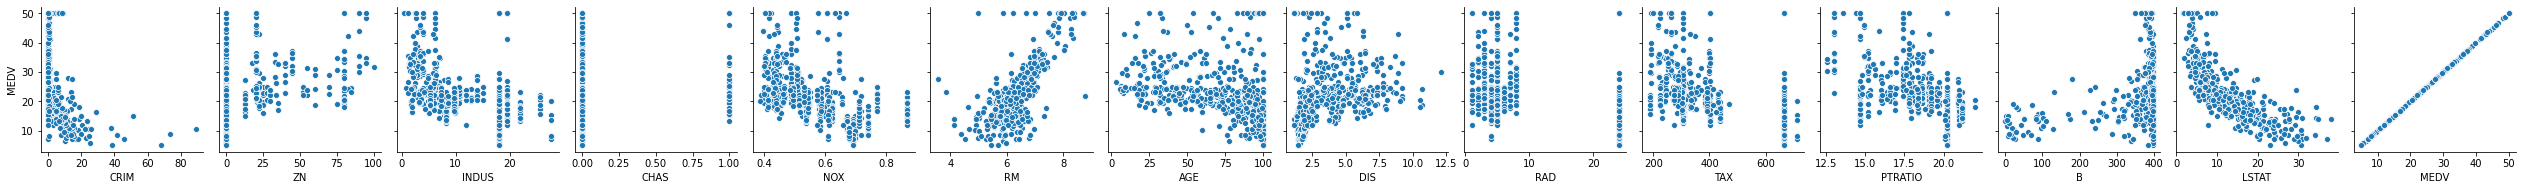

In [ ]:
from seaborn import pairplot
pairplot(boston, x_vars=boston.columns,y_vars='MEDV')
abs(boston.corr()['MEDV']).sort_values(ascending=False)

**A)**
Divida sus datos en Training /Test, usando en una proporcion de 0.8/0.2. 

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(boston,test_size=0.2, random_state=0)

boston_train=train[['LSTAT','RM']]
boston_train_labels=train[['MEDV']]

boston_test=test[['LSTAT','RM']]
boston_test_labels=test[['MEDV']]


**B)** Utilice validación cruzada y K-folding para comparar el desempeño de diferentes modelos lineales utilizando solamente los datos de Training. Utilice la métrica de desempeño ``scoring='neg_root_mean_squared_error'``. Los modelos a comparar son:
* Regresión lineal unidimensional utilizando cada uno de los features escogidos.
* Regresión lineal bidimensional utilizando ambos features.
* Regresión polinomial cuadrática unidimensional utilizando cada uno de los features escogidos.
* Regresión polinomial cuadrática  bidimensional utilizando ambos features.
En base a estos resultados, elija un modelo. 

In [ ]:
import sklearn.preprocessing as pp
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

([<matplotlib.axis.XTick at 0x7f5a9c2fe278>,
 [Text(0, 0, 'LSTAT M = 1'),
  Text(0, 0, 'RM M = 1'),
  Text(0, 0, 'LSTAT + RM M = 1'),
  Text(0, 0, 'LSTAT M = 2'),
  Text(0, 0, 'RM M = 2'),
  Text(0, 0, 'LSTAT + RM M = 2')])

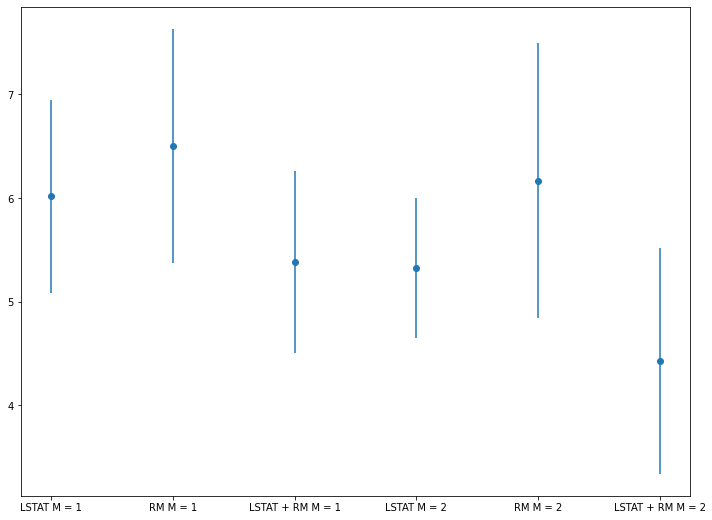

In [ ]:
cv=10
modelos=np.arange(0,6,1)
labels=['LSTAT M = 1', 'RM M = 1', 'LSTAT + RM M = 1','LSTAT M = 2', 'RM M = 2', 'LSTAT + RM M = 2']
var=[["LSTAT"],["RM"],["LSTAT","RM"],["LSTAT"],["RM"],["LSTAT","RM"]]
deg=[1,1,1,2,2,2]
scores_mean=np.zeros(len(labels))
scores_std=np.zeros(len(labels))
coeffs=[]
for nlabel, label in enumerate(labels):
  lin_reg_aux = LinearRegression(fit_intercept=False)
  modelo_aux=Pipeline([('scaler',StandardScaler()),('features', pp.PolynomialFeatures(degree=deg[nlabel])),
                             ('regression', LinearRegression(fit_intercept=False))])
  scores_aux=cross_val_score(modelo_aux, boston_train[var[nlabel]], boston_train_labels, cv=cv, scoring='neg_root_mean_squared_error')
  scores_mean[nlabel]=(-scores_aux).mean()
  scores_std[nlabel]=(-scores_aux).std()
  modelo_aux.fit(boston_train[var[nlabel]], boston_train_labels)
  coeffs.append(modelo_aux.named_steps['regression'].coef_)
fig=plt.figure(figsize=((12,9)))
plt.errorbar(modelos, scores_mean, scores_std, fmt='o')
plt.xticks(np.arange(6), labels)

In [ ]:
print(coeffs[1],coeffs[-2])

[[22.61188119  6.50563151]] [[21.37930868  6.03972837  1.23257251]]


In [ ]:
scores_mean[-1]

4.4314989325568845

**C)** Considere la regresión polinomial  cuadrática de los ultimos dos casos. Añada un término de regularización LASSO y RIDGE. Utilice validación cruzada para medir su desempeño, ¿cómo se compara a los casos anteriores? ¿Puede elegir los valores óptimos para la regularización?

([<matplotlib.axis.XTick at 0x7f68c89fd6d8>,
 [Text(0, 0, 'LSTAT M = 2 LASSO'),
  Text(0, 0, 'LSTAT M = 2 RIDGE'),
  Text(0, 0, 'RM M = 2 LASSO'),
  Text(0, 0, 'RM M = 2 RIDGE'),
  Text(0, 0, 'LSTAT+RM M = 2 LASSO'),
  Text(0, 0, 'LSTAT+RM M = 2 RIDGE')])

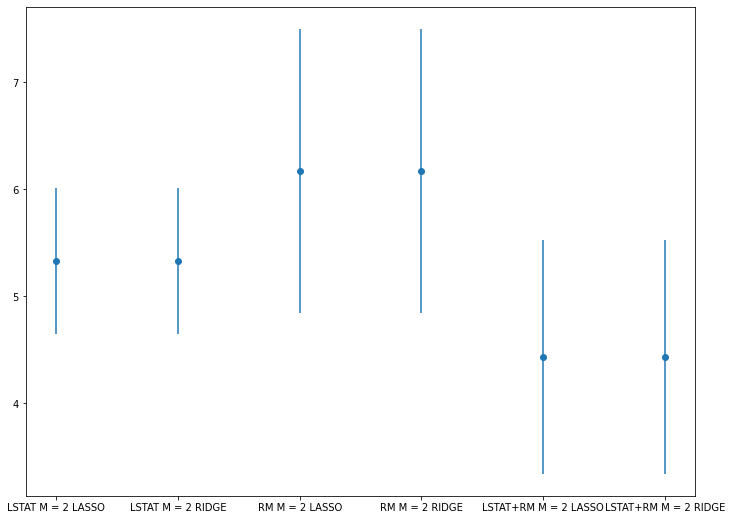

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

cv=10
modelos=np.arange(0,6,1)
labels=['LSTAT M = 2 LASSO', 'LSTAT M = 2 RIDGE', 'RM M = 2 LASSO', 'RM M = 2 RIDGE','LSTAT+RM M = 2 LASSO', 'LSTAT+RM M = 2 RIDGE']
var=[["LSTAT"],['LSTAT'],["RM"],["RM"],["LSTAT","RM"],["LSTAT","RM"]]
deg=2*np.ones(len(labels))
scores_mean=np.zeros(len(labels))
scores_std=np.zeros(len(labels))
alphas = np.logspace(-20, -5, 25, base=np.e)
best_fits=[]
best_params=[]
for nlabel, label in enumerate(labels):
  lin_reg_aux = LinearRegression(fit_intercept=False)
  if(label[-1]=='O'):
    modelo_aux=Pipeline([('scaler',StandardScaler()),('features', pp.PolynomialFeatures(degree=int(deg[nlabel]))),
                             ('regression', Lasso(fit_intercept=False, tol=1e-3, max_iter=10000))])
    parameters={'regression__alpha':alphas}
  else:
    modelo_aux=Pipeline([('scaler',StandardScaler()),('features', pp.PolynomialFeatures(degree=int(deg[nlabel]))),
                             ('regression', Ridge(fit_intercept=False))])
    parameters={'regression__alpha':alphas}
  grilla=GridSearchCV(modelo_aux,parameters,cv=cv,scoring='neg_root_mean_squared_error',refit=True)
  grilla.fit(boston_train[var[nlabel]],boston_train_labels)
  best_fits.append(grilla.best_estimator_)
  best_params.append(grilla.best_params_)
  scores_mean[nlabel]=(-grilla.best_score_)
  scores_std[nlabel]=(grilla.cv_results_['std_test_score'][grilla.best_index_])
fig=plt.figure(figsize=((12,9)))
plt.errorbar(modelos, scores_mean, scores_std, fmt='o')
plt.xticks(np.arange(6), labels)

Test Absolute Differences
Max MEDV    27.638337
dtype: float64
Median 2.3453526407172456
25th-percentile 1.2047759970158616
75th-percentile 4.072692185232045
90th-percentile 6.420050209383371 

RMSE (test) 5.305211516752068
MAE (test) 3.3415044338345705


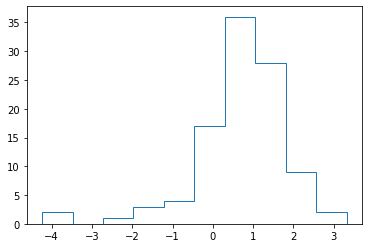

In [ ]:
boston_test_predictions = best_fits[-1].predict(boston_test[['LSTAT','RM']])

abserror = np.abs(boston_test_predictions - boston_test_labels)
print('Test Absolute Differences')
print('Max', abserror.max())
print('Median', np.median(abserror))
print('25th-percentile', np.percentile(abserror, 25))
print('75th-percentile', np.percentile(abserror, 75))
print('90th-percentile', np.percentile(abserror, 90), '\n')

lin_mse = mean_squared_error(boston_test_labels, boston_test_predictions)
print('RMSE (test)', np.sqrt(lin_mse))
print('MAE (test)', mean_absolute_error(boston_test_labels, boston_test_predictions))

h = plt.hist(np.log(np.asarray(abserror)), 10, histtype='step',label="LSTAT + RM, M = 2 RIDGE")

**D)**  (*) Considere una Regresión polinomial de grado ``M`` con regularización (LASSO o RIDGE). Utilice validación cruzada para obtener la mejor combinación de parámetros ``M`` y ``alpha`` (el regulador)

In [ ]:
modelo=Pipeline([('features',pp.PolynomialFeatures()),('ridge',Ridge(fit_intercept=False))])

alphas=np.logspace(-20, -5, 25, base=np.e)
degree=[1,2,3,4,6]

parameters={'features__degree':degree,'ridge__alpha':alphas}
grilla=GridSearchCV(modelo,parameters,cv=cv,scoring='neg_root_mean_squared_error',refit=True)
grilla.fit(boston_train[['LSTAT','RM']],boston_train_labels)
print(grilla.best_params_)

In [ ]:
modelo=Pipeline([('features',pp.PolynomialFeatures()),('lasso',Lasso(fit_intercept=False, tol=1e-3, max_iter=10000))])

alphas=np.logspace(-20, -5, 25, base=np.e)
degree=[1,2,3,4]

parameters={'features__degree':degree,'lasso__alpha':alphas}
grilla=GridSearchCV(modelo,parameters,cv=cv,scoring='neg_root_mean_squared_error',refit=True)
grilla.fit(boston_train[['LSTAT','RM']],boston_train_labels)
print(grilla.best_params_)

**E)**  (*) Opcional: Explore el dataset. Pruebe incluír mas features,  y explore las diversas funcionalidades vistas en clase: Estratificación, distintas funciones de base, etc.